<a href="https://colab.research.google.com/github/Yixian-ch/Record_project/blob/main/LYSL005_2022_rnn_Xingyu_CHEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Générer du texte avec des RNN

Nous utiliserons pour cela un module adapté par Donald Dong qui permet d'entraîner rapidement un RNN pour la génération de texte, appelé `rnn-text-gen`. La documentation autour du module en question est [disponible sur Github](https://github.com/donaldong/rnn-text-gen).

Contrairement au module `markovify`, nous n'allons pas installer le module et l'importer comme n'importe quel module Python. Nous allons ici devoir récupérer le répertoire git et l'importer ici.

On commence pour cela par cloner le répertoire Git.

In [1]:
!git clone https://github.com/donaldong/rnn-text-gen.git

Cloning into 'rnn-text-gen'...
remote: Enumerating objects: 331, done.
remote: Total 331 (delta 0), reused 0 (delta 0), pack-reused 331 (from 1)
Receiving objects: 100% (331/331), 318.05 KiB | 5.39 MiB/s, done.
Resolving deltas: 100% (182/182), done.


Pensez à remplacer le fichier 'text_generator.py' présent dans le répertoire 'rnn-text-gen/src' par le fichier disponible sur iCampus afin de pouvoir faire tourner le reste du code sous Tensorflow 2. Voir les détails de la manipulation sur iCampus.

Il nous faut alors dire au système (ici, notre système virtuel) où se trouve le module que l'on a récupé. On le fait à l'aide du code dans la cellule suivante.

In [3]:
import sys
sys.path.insert(0,'/content/rnn-text-gen')



Il nous faut maintenant importer les classes et libraires pertinentes

In [4]:
# On importe les classes issues du module custom que nous avons cloné
from src.text_generator import RNNTextGenerator
from src.dataset import Dataset

# On importe les librairies classiques nécessaires pour la suite
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# BasicRNNCell` is not available with Keras 3, j'essaie de changer ma version de tensorflow
# WARNING:tensorflow:From /usr/local/lib/python3.10/dist-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.

Instructions for updating:
non-resource variables are not supported in the long term


In [1]:
!pip install tensorflow==2.10


On peut alors commencer à entraîner notre RNN.

On commence par charger notre corpus d'entraînement. Ici, le module vient avec quelques corpus, dont on peut regarder rapidement à quoi ils ressemblent.

In [21]:
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 11420: invalid start byte
# dans le terminal de linux j'ai utilisé iconv -f utf-8 880jr07.txt > 880jr07.txt
with open('/content/rnn-text-gen/data/pg800.txt') as f:
    text = f.read()
print(text[:400])

﻿The Project Gutenberg eBook of Le tour du monde en quatre-vingts jours
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not loca


In [22]:
seq_length = 25
learning_rate = 0.01
epoch = 1
batch_size = 25

In [24]:
quatre_vint_jours_dataset = Dataset(['/content/rnn-text-gen/data/pg800.txt'], seq_length)

In [32]:
from tensorflow.keras.layers import GRU

In [38]:
from tensorflow.keras.layers import LSTMCell, RNN

rnn_model = RNNTextGenerator(
    seq_length,
    quatre_vint_jours_dataset.vocab_size,
    rnn_cell=tf.compat.v1.nn.rnn_cell.LSTMCell,
    learning_rate=0.0001,
    epoch=epoch,
    batch_size=batch_size,
)


/content/rnn-text-gen/src/text_generator.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  self._tf_rnn_cell = rnn_cell(
/content/rnn-text-gen/src/text_generator.py:115: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(


In [44]:
rnn_model = RNNTextGenerator(
    seq_length,
    quatre_vint_jours_dataset.vocab_size,
    rnn_cell=tf.compat.v1.nn.rnn_cell.BasicRNNCell, # tf.keras.layers.LSTM, GRU
    learning_rate=learning_rate,
    epoch=epoch,
    batch_size=batch_size,
)

/content/rnn-text-gen/src/text_generator.py:106: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  self._tf_rnn_cell = rnn_cell(
/content/rnn-text-gen/src/text_generator.py:115: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(


In [45]:
rnn_model_scores = rnn_model.fit(
    quatre_vint_jours_dataset,
    save_scores=True
)

On peut alors produire une visualisation graphique de l'évolution de ces scores.

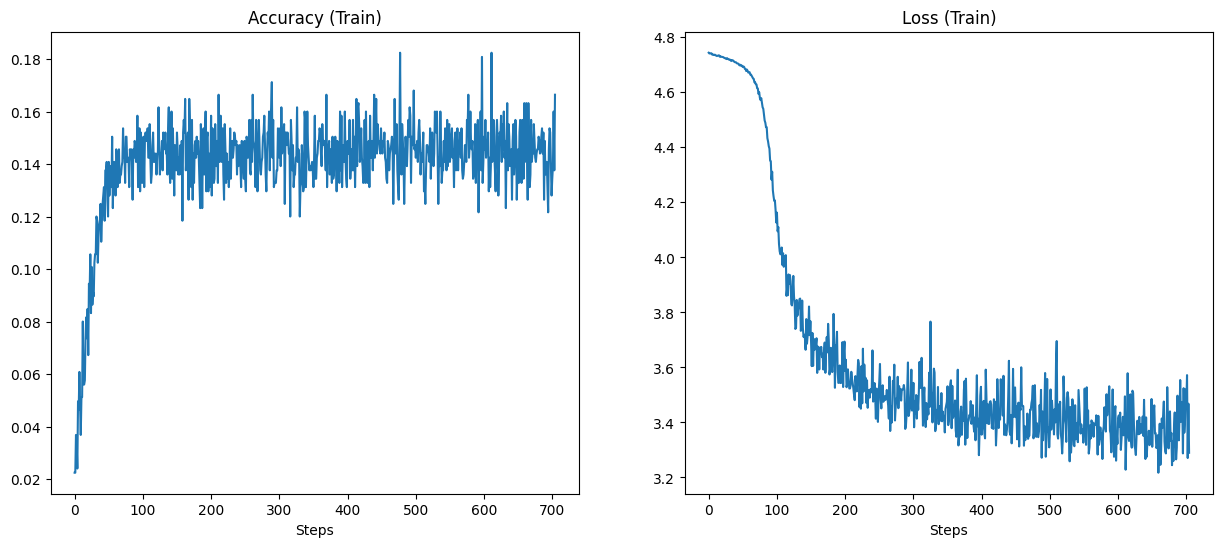

In [41]:
fig, axes = plt.subplots(figsize=(15, 6), ncols=2)
rnn_model_scores['accuracy'].plot(
    ax=axes[0], title='Accuracy (Train)'
)
rnn_model_scores['loss'].plot(
    ax=axes[1], title='Loss (Train)'
)
for ax in axes:
    ax.set(xlabel='Steps')

In [46]:
final_accuracy = rnn_model_scores['accuracy'].iloc[-1]
final_loss = rnn_model_scores['loss'].iloc[-1]

print(f"Final Accuracy: {final_accuracy}")
print(f"Final Loss: {final_loss}")


Final Accuracy: 0.41760000586509705
Final Loss: 2.093048334121704


In [28]:
# On importe la fonction native du module permettant de fixer une durée maximale à l'entraînement
from src.time_limit import time_limit

# On définit la durée de l'entraînement
for _ in time_limit(seconds=30):
  # On affine le modèle
  rnn_model.fit(quatre_vint_jours_dataset)
  acc, loss = rnn_model.score(quatre_vint_jours_dataset)
  # On imprime à chaque epoch la précision et la valeur de la loss function
  print('test acc: {}, test loss: {}'.format(
        acc, loss
    ))
  # On demande à chaque epoch d'imprimer une séquence de 100 caractères prédits à partir de la séquence initiale 'Yes, but '
  start_seq = 'Yes, but '
  print(start_seq + rnn_model.generate(
        quatre_vint_jours_dataset,
        start_seq,
        100
    ))
  print('-----------------------')

test acc: 0.43327999114990234, test loss: 1.9319759607315063


/content/rnn-text-gen/src/text_generator.py:106: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  self._tf_rnn_cell = rnn_cell(
/content/rnn-text-gen/src/text_generator.py:115: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(


Yes, but les, Phileus à jine
binnespeces ccmpé en prenvait mes
ievait Lenveni leux lengeres d'entrout!», pred
-----------------------
test acc: 0.45695996284484863, test loss: 1.8374124765396118
Yes, but à ci au mice. Si sa mistitôts Antrit. Mus.o natita le nnier.

a boisauté le dille ford pricue replés
-----------------------


KeyboardInterrupt: 

Quelque soit la performance de votre RNN, il est en tout cas déjà prêt pour la génération de phrase. Générer une séquence se fait à l'aide de la fonction `generate()`. La fonction prend en argument le dataset (c'est-à-dire le dictionnaire contenant les équivalences entre les vecteurs one-hot et les symboles correspondants), la séquence à partir de laquelle prédire, et le nombre de caractères à prédire.

In [29]:
# Pour des raisons de lisibilité, on définit la séquence d'amorce dans une variable à part
start_seq = 'bien sûr '

# On imprime ici directement l'amorce et le texte généré (mais on pourrait enregistrer le texte généré dans une variable par exemple)
print(start_seq + rnn_model.generate(
        quatre_vint_jours_dataset,
        start_seq,
        500
    ))
# Of course at indly, cool
# ersad so were came
# beguredy and meally from onlen the frond tonetiless, 'a shreds
# ood banchold she
# mem_ up in crock Turtlear stell last anxions meried. you crapale this was should they saying waict torss. 'Thered at eswere little Engubles at larger;
#    Ahe wootiondering eldaroud the once had-inly such anned
# court vurrowily, yerring to sildsn thoono slees; on its fred, jeating they, and boing to
# aryiods and memnoking very sing but!' raven tryice court! Alice does not and merisher,
# on peut voir que le résultat est mauvais

/content/rnn-text-gen/src/text_generator.py:106: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  self._tf_rnn_cell = rnn_cell(
/content/rnn-text-gen/src/text_generator.py:115: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(


bien sûr bité dis futle homme», la
mette, les
griguour
de le déchit Mr.
pâta en menlubais fout» juss, Sumulien son husta
aien, las
de foiur intitervent à viffarte fauloins
quelques, finque eût qui puus-rentil, aucait le hèmal. Lu mélonis au paret que, autigéfit contailements
ders d'accifut l'austions derfffi, el le prentilefffitificès de Khandand--ce romme un sujet. Il-vonaux, sir, cette avirfer du _Cussifins qu'en inteundit gris
frahinait hintà cesss le la garçont levoudagmimem-Unes réppuragonutiong-com


Comme dit plus haut, vous pouvez entraîner des RNN plus spécifiques, à savoir des LSTM et des réseaux de type GRU. Il suffit pour cela notamment de remplacer dans la fonction d'entraînement le `BasicRNNCell` par `LSTMCell` ou `GRUCell` (et modifier les valeurs des autres arguments si besoin).

## Exercice

- Quels sont les paramètres qui vous permettent d'améliorer les résultats pour un petit corpus ?
- Quel est l'impact de la taille du corpus ?
- Quelle est la performance du RNN sur la prédiction du wikiCréole ?
- Quel est le type de réseau de neurones qui marche le mieux (sur vos données) ?

## Les paramètres
Sur le site de référence j'ai trouvé :
- seq_length
- vocab_size
- rnn_cell=tf.nn.rnn_cell.BasicRNNCell
- n_neurons=100
- activation=tf.tanh
- optimizer=tf.train.AdamOptimizer
- learning_rate=0.001
- epoch=5
- batch_size=25
- name='RNNTextGenerator'
- logdir=None
Si on veut améliorer nos résultats, on peut modifier les paramètres comme `optimizer`,`learning_rate`, qui est un paramètre artificiel,  `batch_size` ici si on est sur un petit corpus, on n'aurait pas besoin de lui, `seq_length`, `vocab_size`, `epoch` qui peut augmenter le nombre d'epoch pour améliorer la qualité

## taille du corpus
D'abord, quand on construit un modèle de RNN, on doit prendre en compte la taille d'un corpus, s'il est grand, notre modèle peut être très lourde, qu'il fonctionne lentement. Et notre modèle peut être fixe très bien avec notre corpus avec un taux de précision très haute, mais il ne march pas pour d'autre corpus, le problème d'overfitting.
Et si un corpus est grand, souvent, l'entrainement est très coûteux et nécessite plus de temps
En gros, en fonction de la taille de corpus, on doit faire attention aux paramètres et le prblème d'optimalization

# RNN wikicréole
Je pense que la performance va être mauvaise, parce que des langages créoles est je cite de Wikipédia : ` est une langue aussi complexe et aussi riche que n’importe quelle autre langue native`
Donc, on aurait besoin de plus de neurones ou d'autres modèles de neurones

# Réseaux neurones
## Pour le keras layers RNN
- Final Accuracy: 0.1664000004529953
- Final Loss: 3.2897589206695557
## pour le basicRNNCell
- Final Accuracy: 0.41760000586509705
- Final Loss: 2.093048334121704
j'arrive pas à utiliser le GNU
donc sur les deux modèles, le basicRNNCell est le meuilleur